In [ ]:
# Data Processing
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("directory_to_the_csv_file", index_col=0)

In [ ]:
df.iloc[0:5,0:5]

,AAK1,AASS,AATK,ABAT,ABCA1
GSM338860,6.170397,5.606532,8.186989,7.100655,4.965535
GSM338861,6.112532,5.407005,8.530366,7.131207,4.912667
GSM338863,6.164055,5.518116,7.642412,7.221282,4.962869
GSM338865,6.423721,5.650853,8.372038,7.381892,4.956469
GSM338866,6.631895,5.701830,7.903833,7.641011,4.991327


### Split df to X and Class to y

In [ ]:
# Separate features and target
X = df.drop(columns = ['Class'])
y = df['Class']

## Feature Selection: Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [ ]:
# Compute mutual information
mi = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

       Feature  Mutual Information
801      FOXG1            0.509560
1185      KLK8            0.503506
857        GDA            0.435089
1801     PTPN5            0.434184
1829    RAB40B            0.398203
...        ...                 ...
895      GNAI2            0.000000
1741  PPP1R14C            0.000000
909      GPM6A            0.000000
937      GRIK1            0.000000
1114     ITSN1            0.000000

[2525 rows x 2 columns]


In [ ]:
# Select top k features based on mutual information
k = 500  # Choose the number of top features you want
selector = SelectKBest(mutual_info_classif, k=k)
X_selected = selector.fit_transform(X, y)

### 80/20 Rule

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(289, 500)

### Baseline Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define model architecture

np.random.seed(42)
tf.random.set_seed(42)

# Expand dimensions for CNN input
X_train_expanded = np.expand_dims(X_train_normalized, axis=-1)
X_test_expanded = np.expand_dims(X_test_normalized, axis=-1)

# Define model architecture
model = Sequential([
    # 1D Convolutional Layer
    Conv1D(filters=64, kernel_size=3, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train_expanded.shape[1], 1)),
    MaxPooling1D(pool_size=2),

    # Additional Convolutional Layers
    Conv1D(filters=128, kernel_size=3, activation='selu', kernel_initializer='lecun_normal'),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='selu', kernel_initializer='lecun_normal'),
    MaxPooling1D(pool_size=2),

    # Flatten the output
    Flatten(),

    # Fully Connected Layers
    Dense(469, activation='selu', kernel_initializer='lecun_normal'),
    Dense(87, activation='selu', kernel_initializer='lecun_normal'),
    Dense(16, activation='selu', kernel_initializer='lecun_normal'),

    # Output layer
    Dense(num_classes, activation='softmax')  # Change num_classes to the number of output classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_expanded, y_train_categorical,
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1,
                    validation_data=(X_test_expanded, y_test_categorical))

Epoch 1/500
10/10 [==============================] - 8s 554ms/step - loss: 5.8533 - accuracy: 0.5087 - val_loss: 0.9832 - val_accuracy: 0.8630
Epoch 2/500
10/10 [==============================] - 5s 469ms/step - loss: 0.5391 - accuracy: 0.8547 - val_loss: 0.7359 - val_accuracy: 0.8493
Epoch 3/500
10/10 [==============================] - 3s 329ms/step - loss: 0.2505 - accuracy: 0.9135 - val_loss: 0.3525 - val_accuracy: 0.8767
Epoch 4/500
10/10 [==============================] - 3s 316ms/step - loss: 0.0761 - accuracy: 0.9827 - val_loss: 0.3514 - val_accuracy: 0.8493
Epoch 5/500
10/10 [==============================] - 2s 199ms/step - loss: 0.0414 - accuracy: 0.9896 - val_loss: 0.2289 - val_accuracy: 0.9452
Epoch 6/500
10/10 [==============================] - 2s 181ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2853 - val_accuracy: 0.9178
Epoch 7/500
10/10 [==============================] - 2s 181ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2257 - val_accuracy: 0.9589

## Overfitting test

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Predict probabilities on the training set using normalized and expanded data
y_train_pred_probs = model.predict(X_train_expanded)
# Get predicted class labels for training set
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
# Get true class labels for training set
y_train_true = np.argmax(y_train_categorical, axis=1)
# Calculate training accuracy
train_accuracy = accuracy_score(y_train_true, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Predict probabilities on the test set using normalized and expanded data
y_test_pred_probs = model.predict(X_test_expanded)
# Get predicted class labels for test set
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
# Get true class labels for test set
y_test_true = np.argmax(y_test_categorical, axis=1)
# Calculate test accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 1s 68ms/step
Training Accuracy: 1.0
3/3 [==============================] - 0s 56ms/step
Test Accuracy: 0.9315068493150684


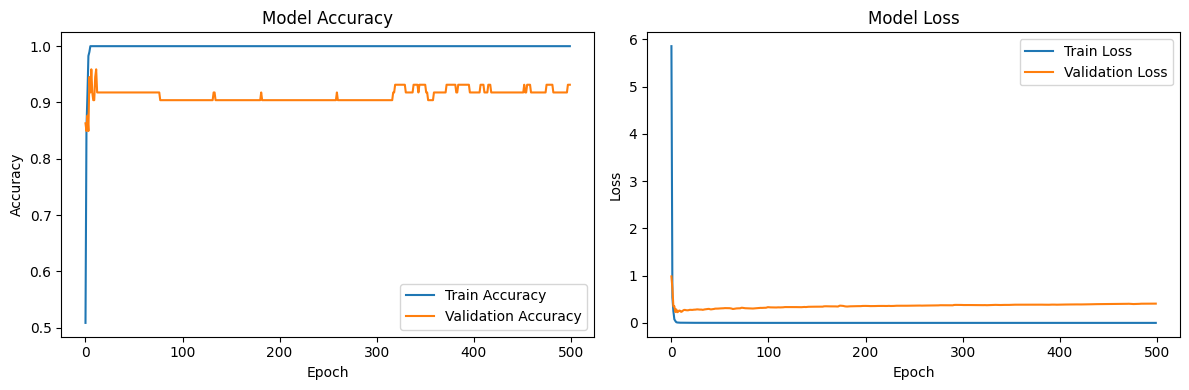

In [ ]:
import matplotlib.pyplot as plt

# Optional: Plot training history
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Confusion Matrix

In [ ]:
unique_labels = y.unique()
print(unique_labels)

['OPNA' 'TBI' 'EEV']


In [ ]:
# Define the class names based on the identified mapping
class_names = ['OPNA', 'TBI', 'EEV']

3/3 [==============================] - 0s 30ms/step


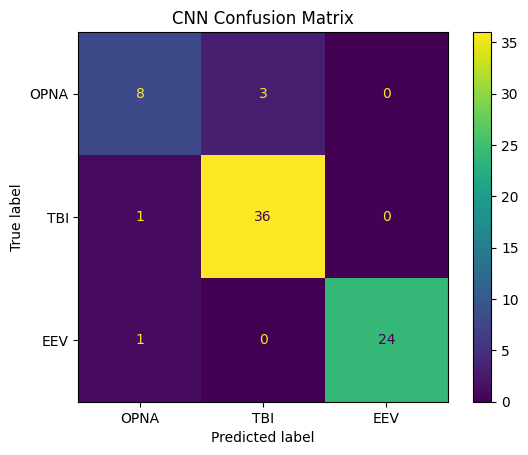

Accuracy: 0.9315068493150684

Classification Report:
              precision    recall  f1-score   support

        OPNA       0.80      0.73      0.76        11
         TBI       0.92      0.97      0.95        37
         EEV       1.00      0.96      0.98        25

    accuracy                           0.93        73
   macro avg       0.91      0.89      0.90        73
weighted avg       0.93      0.93      0.93        73



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Generate confusion matrix
# Get predictions
y_pred = model.predict(X_test_expanded)
y_pred = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test = np.argmax(y_test_categorical, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.viridis)  # You can change the colormap if you prefer
plt.title("CNN Confusion Matrix")
plt.show()

# Print additional metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

### Top 100 Features

In [ ]:
# Select the top 100 features based on mutual information
top_100_features = mi_df['Feature'].head(100)
top_100_features_df = X[top_100_features]

for column in top_100_features_df.columns:
    print(column)

FOXG1
KLK8
GDA
PTPN5
RAB40B
KLRD1
LHX2
SFMBT2
KLF16
GCLM
IL12B
BCL11B
B3GNT5
OXNAD1
SHOX2
MAS1
MEIS1
FGL2
SLC25A23
DLX5
KCNE2
ABR
DPYSL4
ARX
TFPI2
DMP1
CD28
SOSTDC1
ICAM5
CHST1
SHF
MMP24
IFIT1
CD86
CST6
NETO1
HES5
SNX15
TTR
GRIN2C
SNCA
GIMAP4
ITPR1
PDE2A
DBN1
AKAP12
SDC1
PTK2B
ENC1
ACSL5
EPHA4
KCNA4
TBR1
HEBP1
EPHA6
CEBPD
RGS14
EN2
SAT1
BASP1
MYO5B
LMO7
PDE1A
DAB2IP
SOCS3
COMP
KL
CADPS2
FOSL2
FEZF2
ITGBL1
MICAL1
FOLR1
PFN2
PKP2
CX3CL1
ITPKA
MAL2
NEK6
KCTD4
NPY1R
MYC
RASL10A
LIG1
IL16
SOX4
PCDH8
TRPC4
INPP1
PRC1
PARD6A
CHRNA6
CHRNA5
CPE
VIP
KCNJ4
ILF3
MAB21L2
SELL
IL6
